In [5]:
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [4]:
Ts = 1.0

A = np.array([[1]])
B = np.array([[1]])
C = np.array([[1]])
D = np.array([0])

sys_c = ctrl.ss(A, B, C, D)
sys_d = ctrl.c2d(sys_c, Ts, method='zoh')
Ad = sys_d.A
Bd = sys_d.B
Cd = sys_d.C
Dd = sys_d.D

print("Discrete-time system matrices:")
print("Ad:", Ad)
print("Bd:", Bd)

Discrete-time system matrices:
Ad: [[2.71828183]]
Bd: [[1.71828183]]


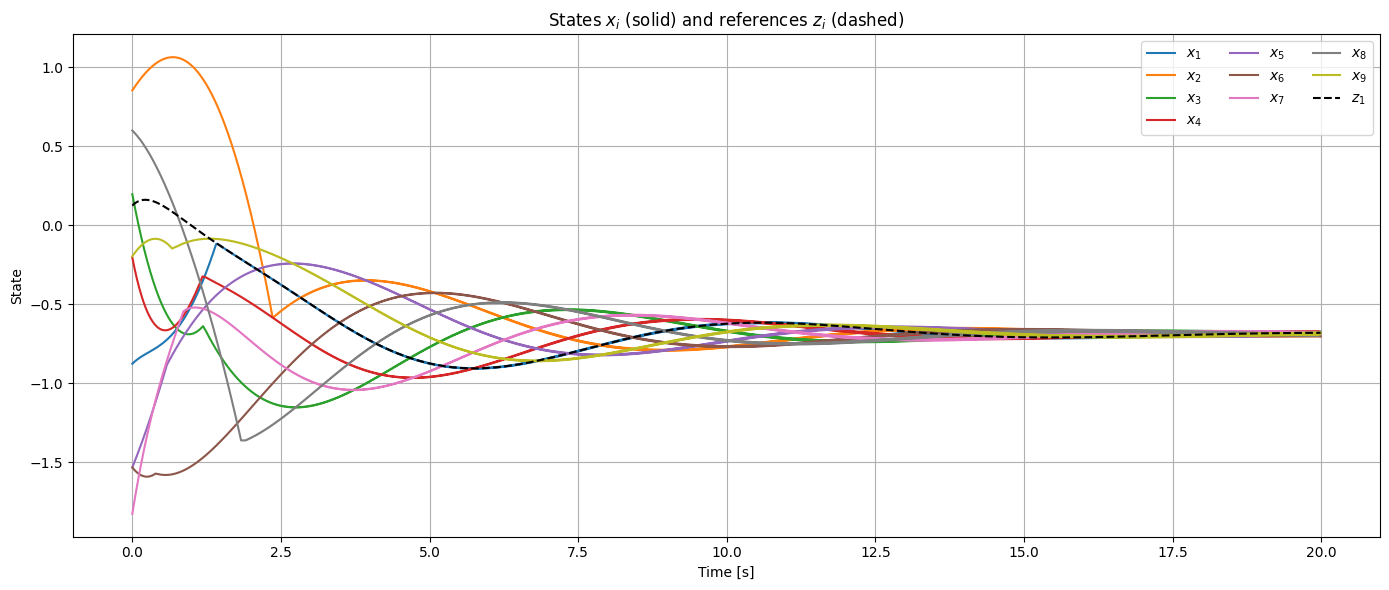

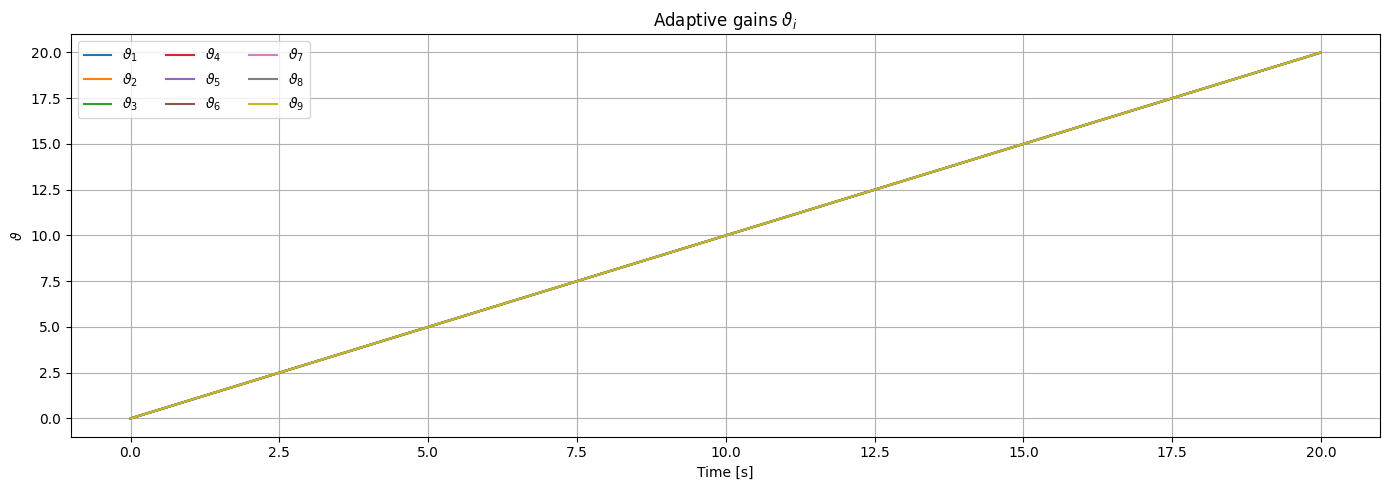

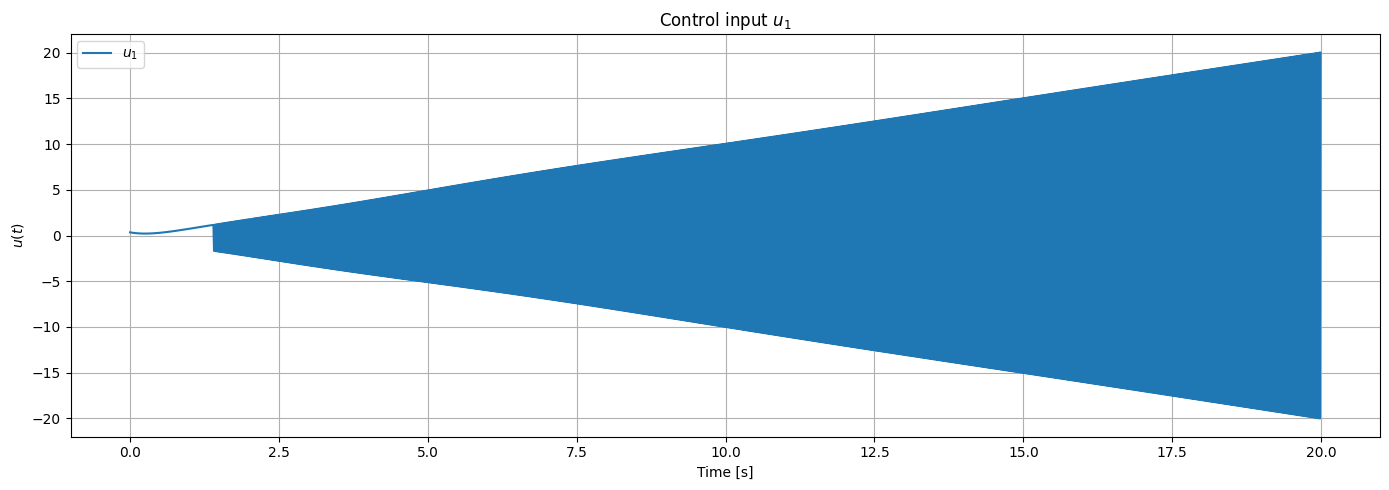

In [ ]:
np.random.seed(42)  

state1_x0 = np.random.uniform(-2, 1)
state2_x0 = np.random.uniform(-2, 1)
state3_x0 = np.random.uniform(-2, 1)
state4_x0 = np.random.uniform(-2, 1)
state5_x0 = np.random.uniform(-2, 1)
state6_x0 = np.random.uniform(-2, 1)
state7_x0 = np.random.uniform(-2, 1)
state8_x0 = np.random.uniform(-2, 1)
state9_x0 = np.random.uniform(-2, 1)

state1_z0 = np.random.uniform(-2, 1)
state2_z0 = np.random.uniform(-2, 1)
state3_z0 = np.random.uniform(-2, 1)
state4_z0 = np.random.uniform(-2, 1)
state5_z0 = np.random.uniform(-2, 1)
state6_z0 = np.random.uniform(-2, 1)
state7_z0 = np.random.uniform(-2, 1)
state8_z0 = np.random.uniform(-2, 1)
state9_z0 = np.random.uniform(-2, 1)

NUM_SIM = 1  # Simulation number for saving plots
NODES = {
    0: {'x0': state1_x0, 'z0': state1_z0, 'neighbors': [3]},
    1: {'x0': state2_x0, 'z0': state2_z0, 'neighbors': [4]},
    2: {'x0': state3_x0, 'z0': state3_z0, 'neighbors': [7]},
    3: {'x0': state4_x0, 'z0': state4_z0, 'neighbors': [6]},
    4: {'x0': state5_x0, 'z0': state5_z0, 'neighbors': [8]},
    5: {'x0': state6_x0, 'z0': state6_z0, 'neighbors': [1]},
    6: {'x0': state7_x0, 'z0': state7_z0, 'neighbors': [2]},
    7: {'x0': state8_x0, 'z0': state8_z0, 'neighbors': [5]},
    8: {'x0': state9_x0, 'z0': state9_z0, 'neighbors': [0]},
}

Ts = 0.01
N = len(NODES)
n_points = 2000
mv = np.zeros(shape=(N, n_points))

def g_i(i, z, neighbors):
    if not neighbors:
        return 0.0
    return sum(z[j] - z[i] for j in neighbors)

def dynamics(t, y, N=len(NODES), gamma=1.0, epsilon=1e-6):
    dydt = np.zeros_like(y)

    x = y[:N]
    z = y[N:2*N]
    vartheta = y[2*N:3*N]

    for i in range(N):
        neighbors = NODES[i]['neighbors']
        g = g_i(i, z, neighbors)

        sigma = x[i] - z[i]
        grad = np.sign(sigma)

        u = g - vartheta[i] * grad
        mv[i, int(t/Ts)-1] = u

        dydt[i] = u                     # dx/dt
        dydt[N + i] = g                 # dz/dt
        if np.abs(sigma) > epsilon:     # adaptive gain update
            dydt[2*N + i] = gamma * 1.0
        else:
            dydt[2*N + i] = 0.0

    return dydt

# === Initial conditions ===
x = np.zeros(shape=(N, n_points))
x0 = np.array([NODES[i]['x0'] for i in range(N)])
z = np.zeros(shape=(N, n_points))
z0 = np.array([NODES[i]['z0'] for i in range(N)])
vartheta = np.zeros(shape=(N, n_points))
vartheta0 = np.zeros(N)
y0 = np.concatenate([x0, z0, vartheta0])

time = 0.0
for n in range(n_points):
    x[:, n] = x0
    z[:, n] = z0
    vartheta[:, n] = vartheta0

    # Update for next iteration
    t_span = np.linspace(time, time+Ts, 2)
    t_eval = np.linspace(time, time+Ts, 2)
    sol = solve_ivp(dynamics, t_span, y0, method='RK45', t_eval=t_eval)
    y0 = sol.y[:, -1]  
    
    x0 = y0[:N]
    z0 = y0[N:2*N]
    vartheta0 = y0[2*N:3*N]

    time += Ts

# === Plot: states ===
t = np.linspace(0, Ts * (n_points - 1), n_points)

plt.figure(figsize=(14, 6))
for i in range(N):
    plt.plot(t, x[i,:], label=f'$x_{i+1}$')
plt.plot(t, z[0,:], 'k--', label=r'$z_{1}$')
plt.title('States $x_i$ (solid) and references $z_i$ (dashed)')
plt.xlabel('Time [s]')
plt.ylabel('State')
plt.legend(ncol=3)
plt.grid()
plt.tight_layout()
plt.savefig(f'img/python-sim/state-evolution_{NUM_SIM}.pdf')

# === Plot: adaptive gains ===
plt.figure(figsize=(14, 5))
for i in range(N):
    plt.plot(t, vartheta[i,:], label=f'$\\vartheta_{i+1}$')
plt.title('Adaptive gains $\\vartheta_i$')
plt.xlabel('Time [s]')
plt.ylabel('$\\vartheta$')
plt.legend(ncol=3)
plt.grid()
plt.tight_layout()
plt.savefig(f'img/python-sim/adaptive_gains_{NUM_SIM}.pdf')

plt.figure(figsize=(14, 5))
#for i in range(N):
plt.plot(t, mv[0,:], label=f'$u_{1}$')
plt.title('Control input $u_1$')
plt.xlabel('Time [s]')
plt.ylabel('$u(t)$')
plt.legend(ncol=3)
plt.grid()
plt.tight_layout()
plt.savefig(f'img/python-sim/control_inputs_{NUM_SIM}.pdf')

plt.show()